In [51]:
import os
import sys
import shutil
import numpy as np
import matplotlib.pyplot as plt

from astropy.visualization import simple_norm
from astropy.io import fits
from photutils.psf import EPSFModel

sys.path.append('/Users/adamboesky/Research/long_transients')

from Extracting.utils import img_ab_mag_to_flux

np.random.seed(22)

# Demonstrate how to inject sources into images

In [52]:
# Load image
hdul = fits.open('/Users/adamboesky/Research/long_transients/Data/ztf_data/ztf_000499_zg_c01_q1_refimg.fits')
img = hdul[0].data.byteswap().newbyteorder()

# Load corresponding EPSF
epsf_data = np.load('/Users/adamboesky/Research/long_transients/Data/catalog_results/000499_01_1/EPSFs/ZTF_g_EPSF.npy')
epsf = EPSFModel(data=epsf_data)

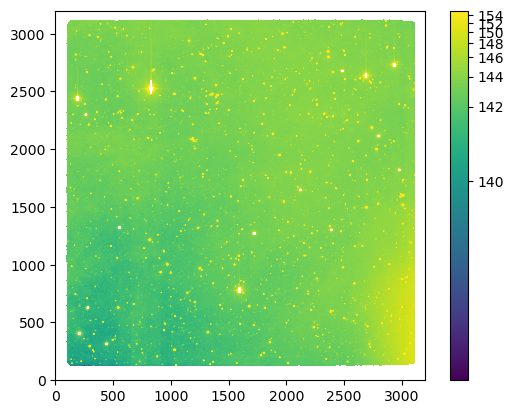

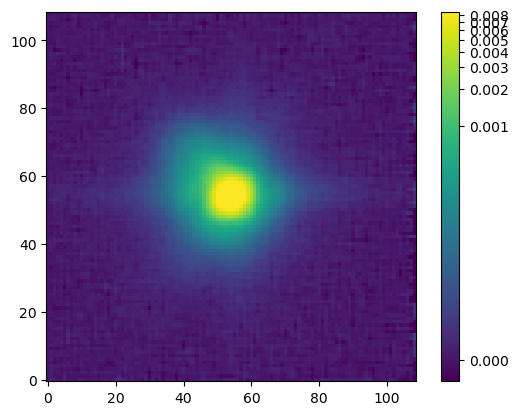

In [53]:
# Plot original image
norm = simple_norm(img, 'log', percent=99.0)
plt.imshow(img, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.show()

# Plot epsf
norm = simple_norm(epsf.data, 'log', percent=99.0)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.show()

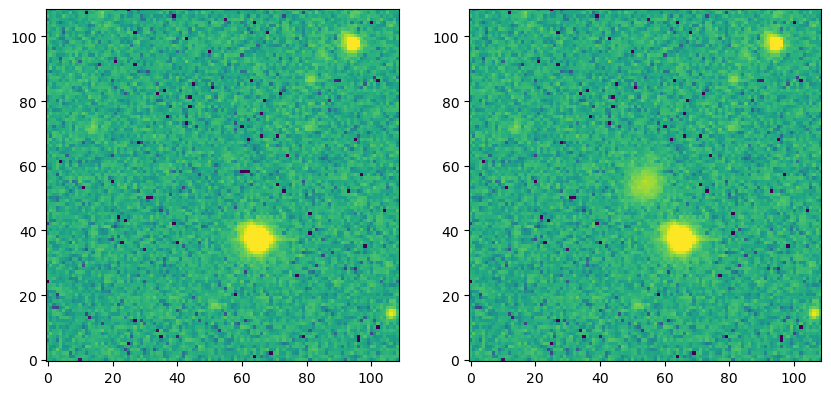

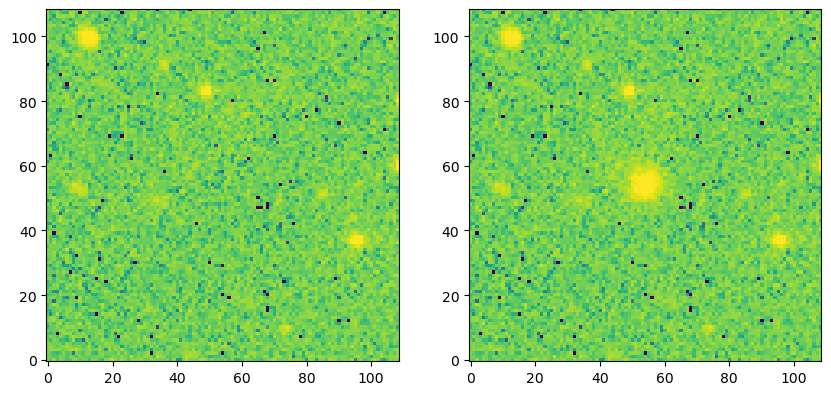

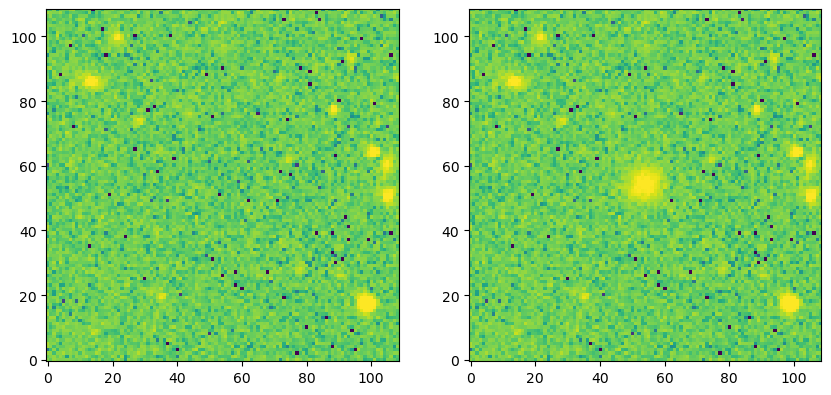

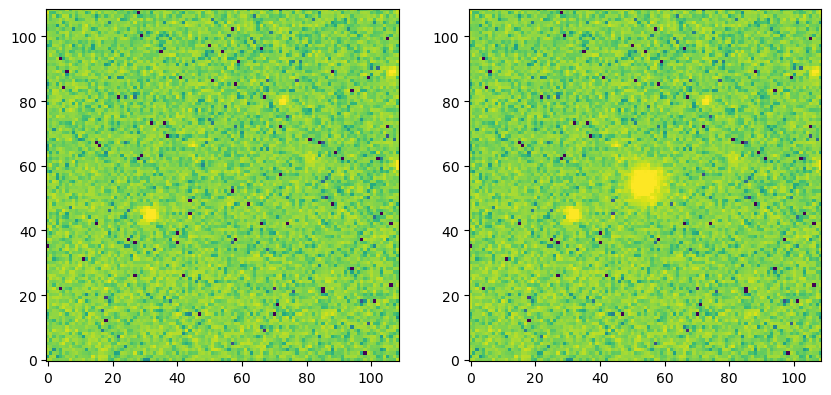

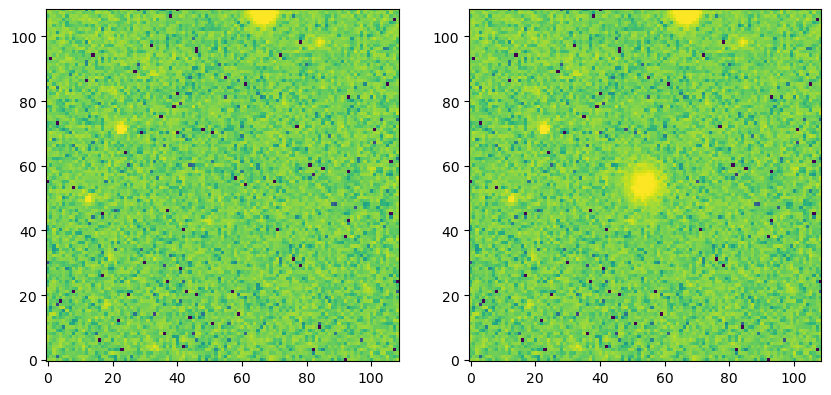

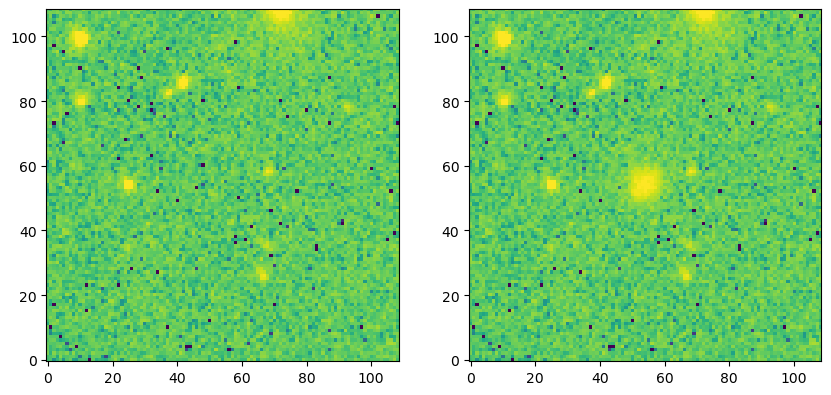

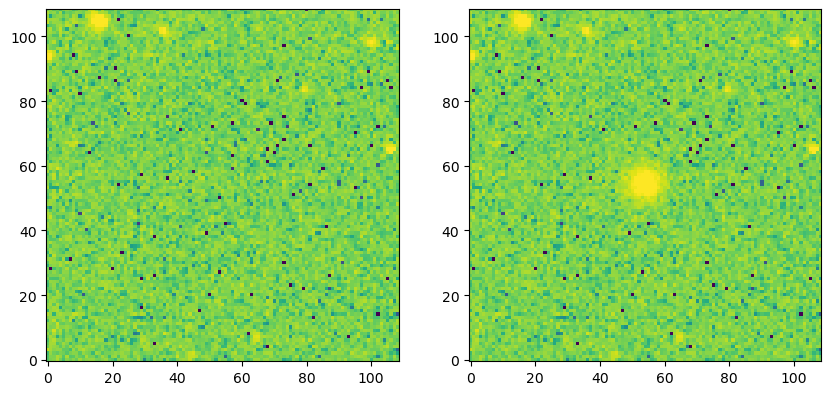

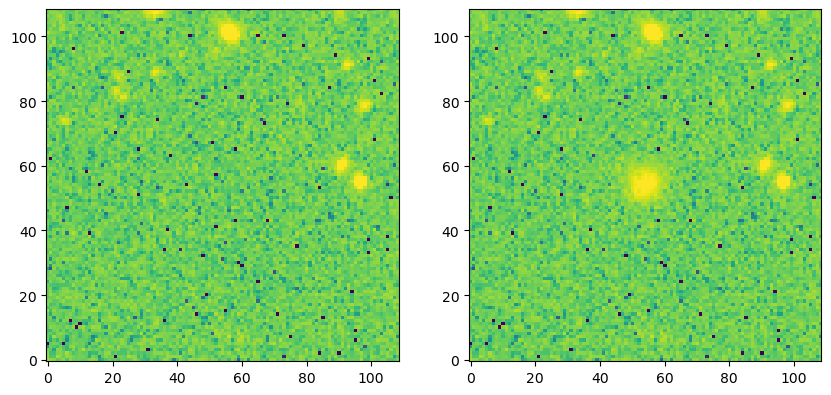

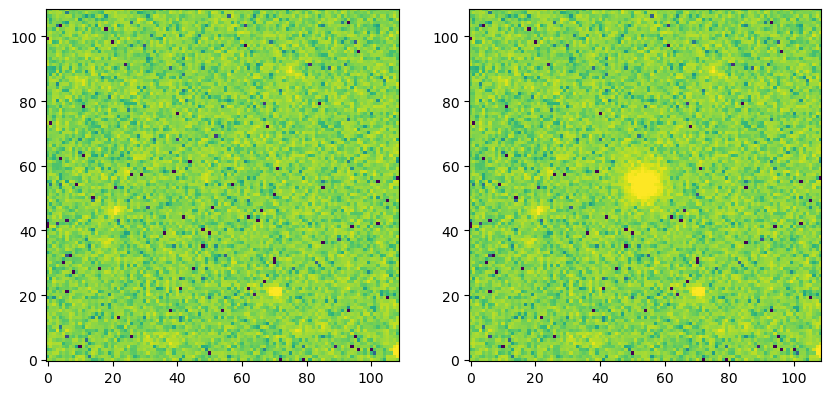

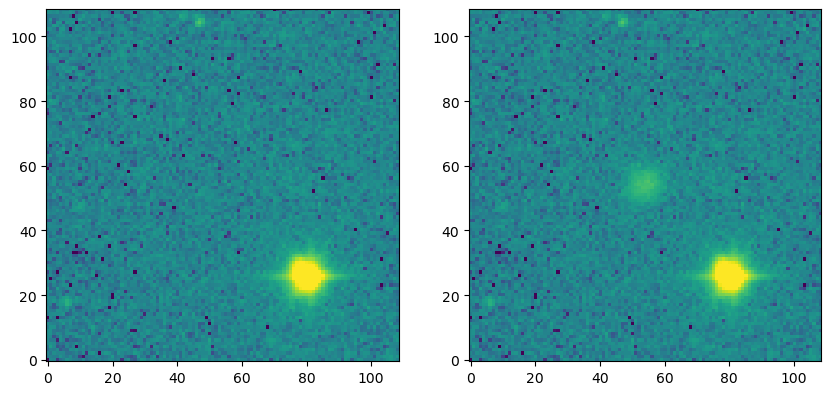

In [54]:
# Inject epsfs in random coordinates
n_injected = 10
psf_half_width = int((epsf.shape[0] - 1) / 2)
xs = np.random.randint(low=psf_half_width, high=img.shape[0] - psf_half_width, size=n_injected)
ys = np.random.randint(low=psf_half_width, high=img.shape[0] - psf_half_width, size=n_injected)

# Get flux scaling
mag_injected = 22
total_flux = img_ab_mag_to_flux(mag_injected, zero_point=hdul[0].header['MAGZP'])

# Add PSF at each random coordinate
img_injected = img.copy()
for x, y in zip(xs, ys):
    img_injected[x - psf_half_width - 1: x + psf_half_width, y - psf_half_width - 1: y + psf_half_width] += epsf_data * total_flux
    norm = simple_norm(img_injected[x - psf_half_width - 1: x + psf_half_width, y - psf_half_width - 1: y + psf_half_width], 'log', percent=99.0)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img[x - psf_half_width - 1: x + psf_half_width, y - psf_half_width - 1: y + psf_half_width], norm=norm, origin='lower', cmap='viridis')
    mappable = axes[1].imshow(img_injected[x - psf_half_width - 1: x + psf_half_width, y - psf_half_width - 1: y + psf_half_width], norm=norm, origin='lower', cmap='viridis')
    plt.show()

# Inject sources into some fields for testing

In [55]:
injection_dir = '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources'


def inject_into_quadrant(
        field: int,
        ccdid: int,
        quadrant: int,
        band: str,
        n_injected: int = 100,
        injection_mags: np.ndarray = np.arange(16, 25, 1),
    ) -> str:
    # Construct filenames
    img_fpath = f'/Users/adamboesky/Research/long_transients/Data/ztf_data/ztf_{str(field).zfill(6)}_z{band}_c{str(ccdid).zfill(2)}_q{quadrant}_refimg.fits'
    res_dirname = f'{str(field).zfill(6)}_{str(ccdid).zfill(2)}_{quadrant}'
    extraction_dirpath = f'/Users/adamboesky/Research/long_transients/Data/catalog_results/{res_dirname}'
    injection_outdirpath = os.path.join(injection_dir, res_dirname)

    # Delete the output directory if it exists
    if os.path.exists(injection_outdirpath):
        shutil.rmtree(injection_outdirpath)
    os.mkdir(injection_outdirpath)

    # Load image
    hdul = fits.open(img_fpath)
    img = hdul[0].data.byteswap().newbyteorder()

    # Load corresponding EPSF
    epsf_data = np.load(open(os.path.join(extraction_dirpath, f'EPSFs/ZTF_{band}_EPSF.npy'), 'rb'))
    epsf = EPSFModel(data=epsf_data)

    # Inject epsfs in random coordinates
    psf_half_width = int((epsf.shape[0] - 1) / 2)
    xs = np.random.randint(low=psf_half_width, high=img.shape[0] - psf_half_width, size=n_injected)
    ys = np.random.randint(low=psf_half_width, high=img.shape[0] - psf_half_width, size=n_injected)

    # Store the coords
    with open(os.path.join(injection_outdirpath, 'coords.npy'), 'wb') as f:
        np.save(f, np.vstack((xs, ys)).T)

    # Store the original fits file
    fits.writeto(filename=os.path.join(injection_outdirpath, 'orig.fits'), data=img, header=hdul[0].header)

    outfnames = []
    for mag_injected in injection_mags:
        outfname = os.path.join(injection_outdirpath, f'mag{str(mag_injected).replace('.', '_')}.fits')
        outfnames.append(outfname)

        # Get flux for given mag
        injection_flux = img_ab_mag_to_flux(mag_injected, zero_point=hdul[0].header['MAGZP'])

        # Add PSF at each random coordinate
        img_injected = img.copy()
        for x, y in zip(xs, ys):
            img_injected[x - psf_half_width - 1: x + psf_half_width, y - psf_half_width - 1: y + psf_half_width] += epsf_data * injection_flux

        # Store data
        fits.writeto(filename=outfname, data=img_injected, header=hdul[0].header)

    return outfnames

In [56]:
# Quadrant data we will inject for
fields = [499]
ccdids = [1]
quadrants = [1]

# Inject and save
for field, ccdid, quadrant in zip(fields, ccdids, quadrants):
    outfiles = inject_into_quadrant(field, ccdid, quadrant, band='g')
    print(f'Saved the following files:\n{outfiles}')

Saved the following files:
['/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000499_01_1/mag16.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000499_01_1/mag17.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000499_01_1/mag18.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000499_01_1/mag19.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000499_01_1/mag20.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000499_01_1/mag21.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000499_01_1/mag22.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000499_01_1/mag23.fits', '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000499_01_1/mag24.fits']


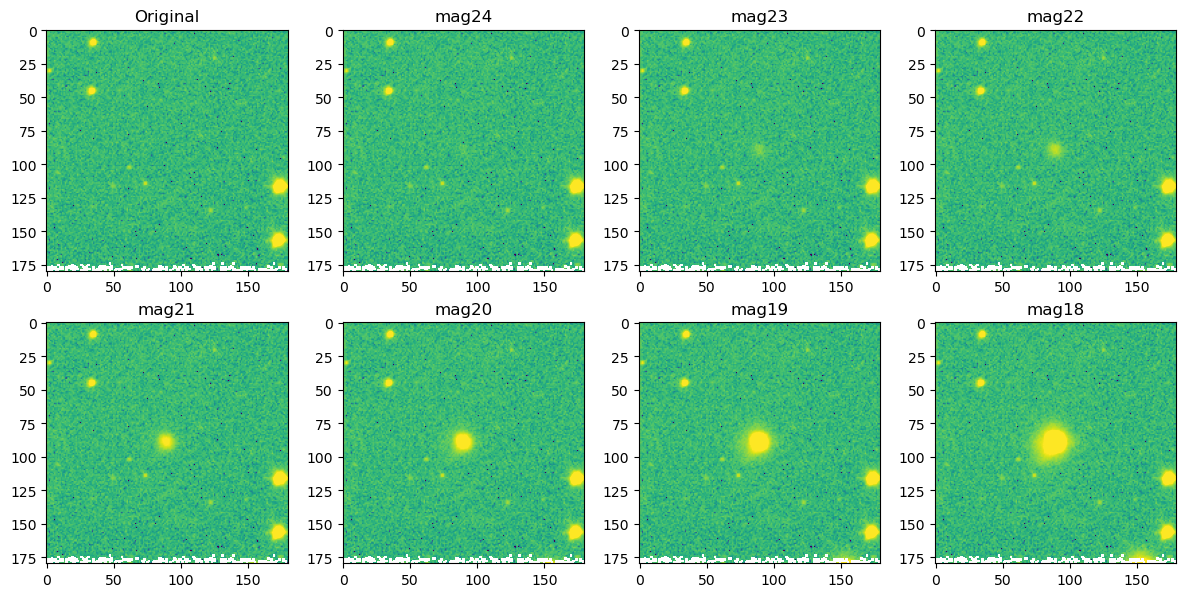

In [57]:
# Confirm outputs look right
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Load some stuff
test_outdir = '/Users/adamboesky/Research/long_transients/Data/ztf_data_injected_sources/000499_01_1'
coords = np.load(open(os.path.join(test_outdir, 'coords.npy'), 'rb'))
orig = fits.open(os.path.join(test_outdir, 'orig.fits'))
x, y = tuple(coords[0])

# Get cutout_norm
cutout_halfwidth = 90
cutout = orig[0].data[x - cutout_halfwidth : x + cutout_halfwidth, y - cutout_halfwidth : y + cutout_halfwidth]

# Plot original
norm = simple_norm(cutout, 'log', percent=99.0)
axes[0][0].imshow(cutout, norm=norm)
axes[0][0].set_title('Original')

# Plot one coord in each image
fnames = [f for f in os.listdir(test_outdir) if f[:3] == 'mag']
args = np.argsort([int(f[3:5]) for f in fnames])[::-1]
for ax, fname in zip(axes.flatten()[1:], np.array(fnames)[args]):
    img = fits.open(os.path.join(test_outdir, fname))
    ax.imshow(img[0].data[x - cutout_halfwidth : x + cutout_halfwidth, y - cutout_halfwidth : y + cutout_halfwidth], norm=norm)
    ax.set_title(fname.split('.')[0])

plt.tight_layout()
plt.show()

# Test Extraction

In [58]:
from Extracting.Source_Extractor import Source_Extractor

# Dict of mags
fpaths = {int(f[3:5]): os.path.join(test_outdir, f) for f in os.listdir(test_outdir) if f[:3] == 'mag'}
fpaths[-999] = os.path.join(test_outdir, 'orig.fits')
coords = np.load(open(os.path.join(test_outdir, 'coords.npy'), 'rb'))

# Load source extractors
sextractors = {mag: Source_Extractor(fpath, 'g') for mag, fpath in fpaths.items()}
print(sextractors)

{24: <Extracting.Source_Extractor.Source_Extractor object at 0x158459730>, 22: <Extracting.Source_Extractor.Source_Extractor object at 0x157fd4110>, 18: <Extracting.Source_Extractor.Source_Extractor object at 0x15888bb90>, 19: <Extracting.Source_Extractor.Source_Extractor object at 0x15d217f50>, 23: <Extracting.Source_Extractor.Source_Extractor object at 0x15888bc20>, 16: <Extracting.Source_Extractor.Source_Extractor object at 0x157bd58e0>, 20: <Extracting.Source_Extractor.Source_Extractor object at 0x15889b590>, 21: <Extracting.Source_Extractor.Source_Extractor object at 0x157ad4740>, 17: <Extracting.Source_Extractor.Source_Extractor object at 0x1588a9280>, -999: <Extracting.Source_Extractor.Source_Extractor object at 0x158380920>}


In [59]:
# Get the results
extraction_results = {}
for mag, sextractor in sextractors.items():
    extraction_results[mag] = sextractor.get_data_table(include_psf=False, include_kron=True)

Extracting sources...
Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:31: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:31: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:31: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:31: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:31: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:31: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:31: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:31: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...
Extracting sources...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:31: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:31: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


In [64]:
n_retrieved = {}
for mag, res in extraction_results.items():
    n_retrieved[mag] = 0
    for coord in coords:
        if np.any((np.abs(res['y'] - coord[0]) < 2) & (np.abs(res['x'] - coord[1]) < 2)):
            n_retrieved[mag] += 1

for mag in np.sort(list(n_retrieved.keys())):
    print(f'{mag}: {n_retrieved[mag]}')

-999: 4
16: 94
17: 94
18: 94
19: 94
20: 93
21: 92
22: 89
23: 87
24: 64
